In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import math
from numpy import asarray
from numpy import save
from numpy import load
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Input
from sklearn.preprocessing import StandardScaler
import os
import tempfile
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
import matplotlib as mpl
import sklearn

In [ ]:
#mount your drive to access the data 
#if you are accessing the data from the shared drive then you need to create a shortcut in your drive to the shared drive first
#How do I mount a shared drive in Google Colab? - google this and follow instructions
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#SCF: This dies with a file not found error for me.
#once drive is mounted then you must specify your path to the data 
#you may need to pay for a high-RAM runtime by signing up for google colab pro+ if you run this in colab. there is a lot of data being read in
dict_train = load('./drive/MyDrive/dca_frames/dca_frames_train.npz')
X_train = dict_train['arr_0']
y_flt_train = load('./drive/MyDrive/dca_frames/dca_labels_train.npy')
y_train = y_flt_train.astype(int)
y_train[y_train>0] = 1 #make binary problem
set(y_train)
len(y_train)

dict_test = load('./drive/MyDrive/dca_frames/dca_frames_test.npz')
X_test = dict_test['arr_0']
y_flt_test = load('./drive/MyDrive/dca_frames/dca_labels_test.npy')
y_test = y_flt_test.astype(int)
y_test[y_test>0] = 1 #make binary problem

len(y_test)

neg, pos = np.bincount(y_train)+np.bincount(y_test) 
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1031279
    Positive: 3419 (0.33% of total)



In [ ]:
np.bincount(y_test
            )

array([274471,   1758])

In [ ]:
print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', X_train.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (755050,)
Test labels shape: (276229,)
Training features shape: (755050, 11, 11, 26)
Test features shape: (276229, 11, 11, 26)


In [ ]:
df = pd.read_csv('./drive/MyDrive/labeledfrequenciesanddca_april_26.csv')

In [ ]:
df['bond_type'].values[df['bond_type']>0] = 1

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
#add resnet layers 
#increase input size by two and use dilation
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 11x11 with 25 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(11, 11, 26)), #change to 11x11x26 if adding dca values to dinuc frequencies
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu', bias_initializer=output_bias),
    tf.keras.layers.Dropout(0.5),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not contact') and 1 for the other ('contact')
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics)

  return model

In [ ]:
EPOCHS = 30
BATCH_SIZE = 2048 #large batch size to ensure each batch contains a few contacts 

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 16)          3760      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 16)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 4, 16)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 32)          0

In [ ]:
mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Not Contacts Detected (True Negatives): ', cm[0][0])
  print('Not Contacts Incorrectly Detected (False Positives): ', cm[0][1])
  print('Contacts Missed (False Negatives): ', cm[1][0])
  print('Contacts Detected (True Positives): ', cm[1][1])
  print('Total Contacts: ', np.sum(cm[1]))

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-5,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot( recall, precision, label=name, linewidth=2, **kwargs)
    plt.ylabel('Precision-TP / (TP + FP)')
    plt.xlabel('Recall-TP / (TP + FN)')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
#train with class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 150.82


In [ ]:
weighted_model = make_model()
#weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    #callbacks=[early_stopping],
    #validation_data=(X_val, y_val),
    # The class weights go here
    class_weight={0: 0.50, 1: 150.82})

Epoch 1/30
369/369 [==============================] - 35s 87ms/step - loss: 0.4505 - tp: 857.0000 - fp: 88966.0000 - tn: 664423.0000 - fn: 804.0000 - accuracy: 0.8811 - precision: 0.0095 - recall: 0.5160 - auc: 0.7761 - prc: 0.0175
Epoch 2/30
369/369 [==============================] - 32s 86ms/step - loss: 0.3900 - tp: 1033.0000 - fp: 77853.0000 - tn: 675536.0000 - fn: 628.0000 - accuracy: 0.8961 - precision: 0.0131 - recall: 0.6219 - auc: 0.8344 - prc: 0.0298
Epoch 3/30
369/369 [==============================] - 31s 83ms/step - loss: 0.3697 - tp: 1062.0000 - fp: 69407.0000 - tn: 683982.0000 - fn: 599.0000 - accuracy: 0.9073 - precision: 0.0151 - recall: 0.6394 - auc: 0.8479 - prc: 0.0384
Epoch 4/30
369/369 [==============================] - 31s 84ms/step - loss: 0.3535 - tp: 1105.0000 - fp: 66720.0000 - tn: 686669.0000 - fn: 556.0000 - accuracy: 0.9109 - precision: 0.0163 - recall: 0.6653 - auc: 0.8621 - prc: 0.0455
Epoch 5/30
369/369 [==============================] - 30s 82ms/step -

KeyError: ignored

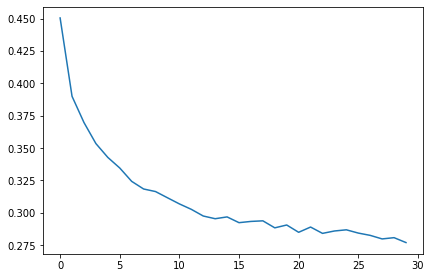

In [ ]:
plot_metrics(weighted_history)
#this gives an error because i am not currently using a validation set so it cant track the validation loss

In [ ]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.24695438146591187
tp :  1193.0
fp :  26454.0
tn :  248017.0
fn :  565.0
accuracy :  0.9021862149238586
precision :  0.04315115511417389
recall :  0.6786120533943176
auc :  0.8700910806655884
prc :  0.2123994380235672

Not Contacts Detected (True Negatives):  248017
Not Contacts Incorrectly Detected (False Positives):  26454
Contacts Missed (False Negatives):  565
Contacts Detected (True Positives):  1193
Total Contacts:  1758


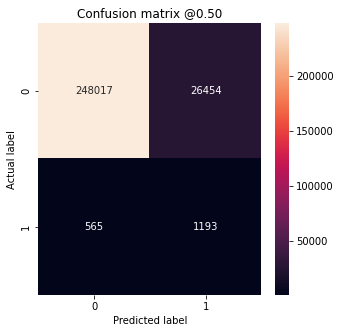

In [ ]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

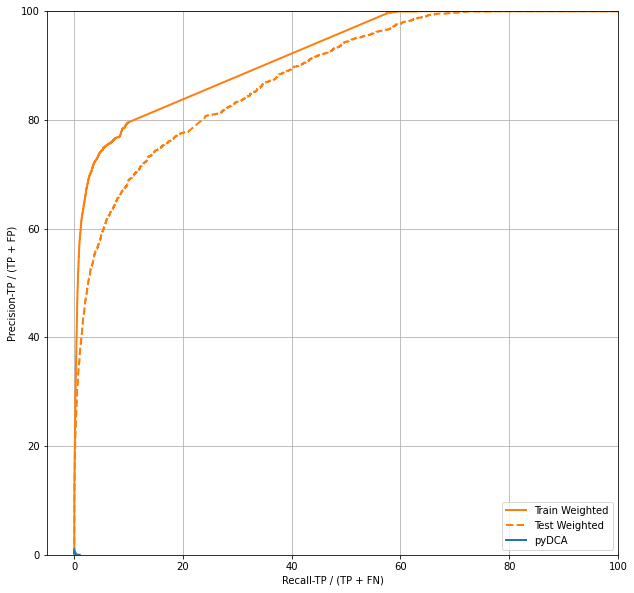

In [ ]:


plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

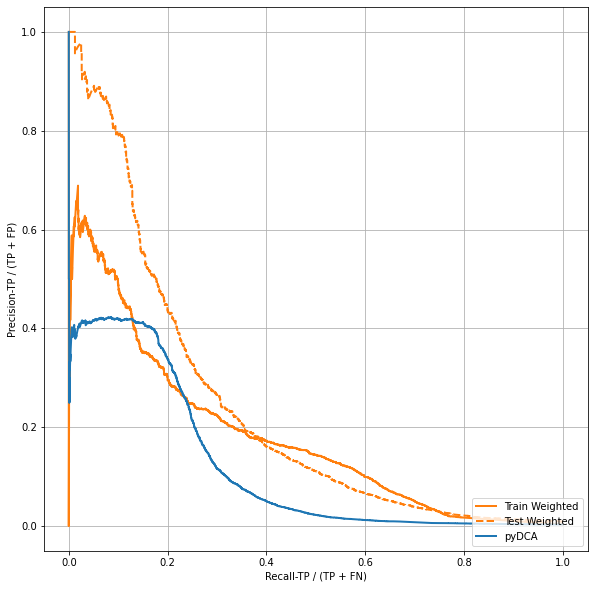

In [ ]:

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')
plot_prc('pyDCA', df.bond_type, df.dca_val)

plt.legend(loc='lower right');